In [1]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [3]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, 'channel_40x40x20_21tsteps_2923_satifying_cases.h5')
p_t, logk = load_data(data_path, ['pressure', 'logk'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('p_t shape is ', p_t.shape)
print('logk shape is ', logk.shape)

p_t shape is  (2923, 20, 40, 40, 21)
logk shape is  (2923, 20, 40, 40, 1)


In [4]:
print('p_t max is ', np.max(p_t))
print('p_t min is ', np.min(p_t))

p_t max is  333.1432647429199
p_t min is  308.82531884981375


In [5]:
depth = 10
nr = logk.shape[0]
train_nr = 2500
test_nr = 2923 - train_nr

In [6]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)
min_p = np.min(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)

max p is  10.287530207856491 , min p is  -10.395436262199155


In [7]:
epsilon = 1e-6
p_t = (p_t - min_p)/(max_p - min_p + 1e-6)

In [8]:
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))
print('max p validation is ', np.max(p_t[test_nr:, ...]), ', min p validation is ', np.min(p_t[test_nr:, ...]))

max p is  0.999999951092884 , min p is  -0.016009034547514525
max p train is  0.999999951092884 , min p train is  0.0
max p validation is  0.999999951092884 , min p validation is  -0.016009034547514525


In [9]:
step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
train_x = np.concatenate([logk[:train_nr, ...], p_t[:train_nr,:, :, :, [0]]], axis = -1)
train_y = p_t[:train_nr, :, :, :, step_index]

test_x = np.concatenate([logk[nr-test_nr:, ...],  p_t[nr-test_nr:, :, :, :, [0]]], axis = -1)
test_y = p_t[nr-test_nr:,:, :, :, step_index]

train_y = train_y.transpose(0, 4, 1, 2, 3)
train_y = train_y[:, :, :, :, :, None]
test_y = test_y.transpose(0, 4, 1, 2, 3)
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2500, 20, 40, 40, 2)
train_y shape is  (2500, 10, 20, 40, 40, 1)
test_x shape is  (423, 20, 40, 40, 2)
test_y shape is  (423, 10, 20, 40, 40, 1)


<Figure size 432x288 with 0 Axes>

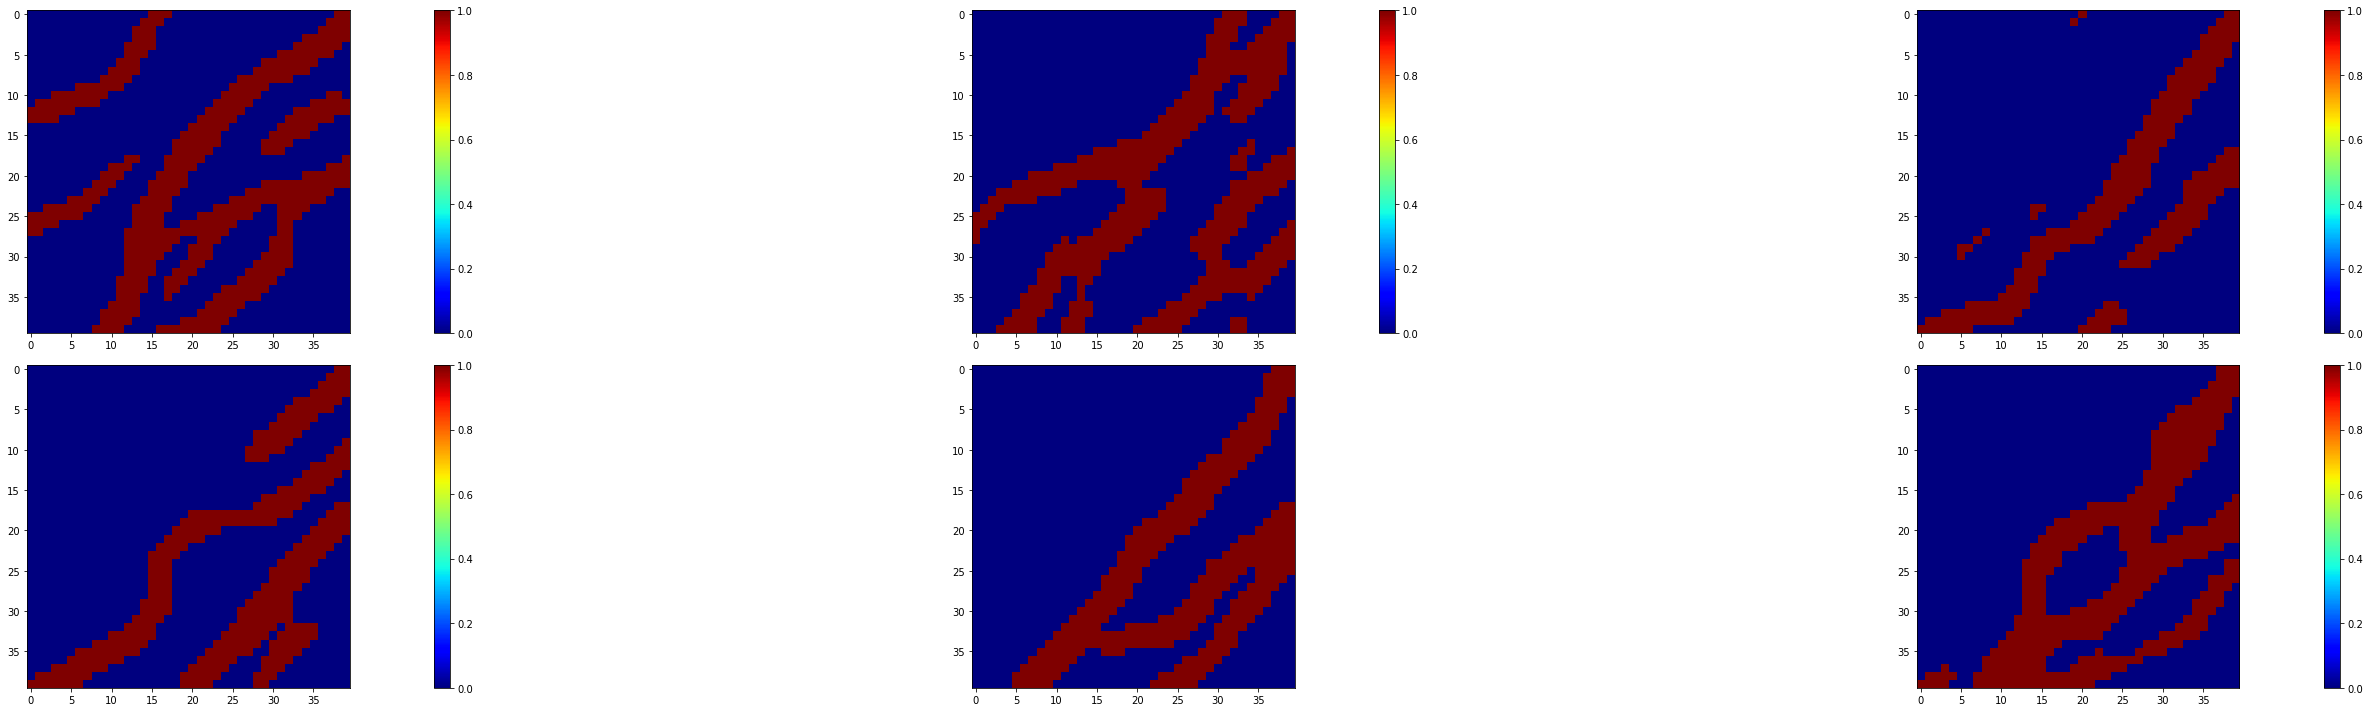

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20, 30, 40, 50]
plt.figure(figsize=(50,10))
for i, k in enumerate(ind_case):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_x[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
plt.show()

In [11]:
input_shape=(20, 40, 40, 2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary(line_length=150)





______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
image (InputLayer)                               (None, 20, 40, 40, 2)            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 10, 20, 20, 16)           880               image[0][0]                                       
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 10, 20, 20, 16)           64      

In [12]:
output_dir = 'saved_models/'
vae_model.load_weights(output_dir + 'saved-model-10steps-bs4-lr3e-4-pressure-detrend-hd-500-filter_16_32_32_64-mse-340-43.58.h5')

In [13]:
pred_list = []
test_batch_size = 10 
batch_num = int(test_nr / test_batch_size) + 1
for i in range(batch_num):
    next_batch_idx = min((i+1)*test_batch_size, test_x.shape[0])
    pred_list.append(vae_model.predict(test_x[i*test_batch_size: next_batch_idx, ...]))

pred = np.concatenate(pred_list, axis = 0)
print(pred.shape)

(423, 10, 20, 40, 40, 1)


In [14]:
p_pred = pred[:, :, :, :, :, 0].transpose(0, 2, 3, 4, 1)
p_true = test_y[:, :, :, :, :, 0].transpose(0, 2, 3, 4, 1)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [16]:
p_pred.shape

(423, 20, 40, 40, 10)

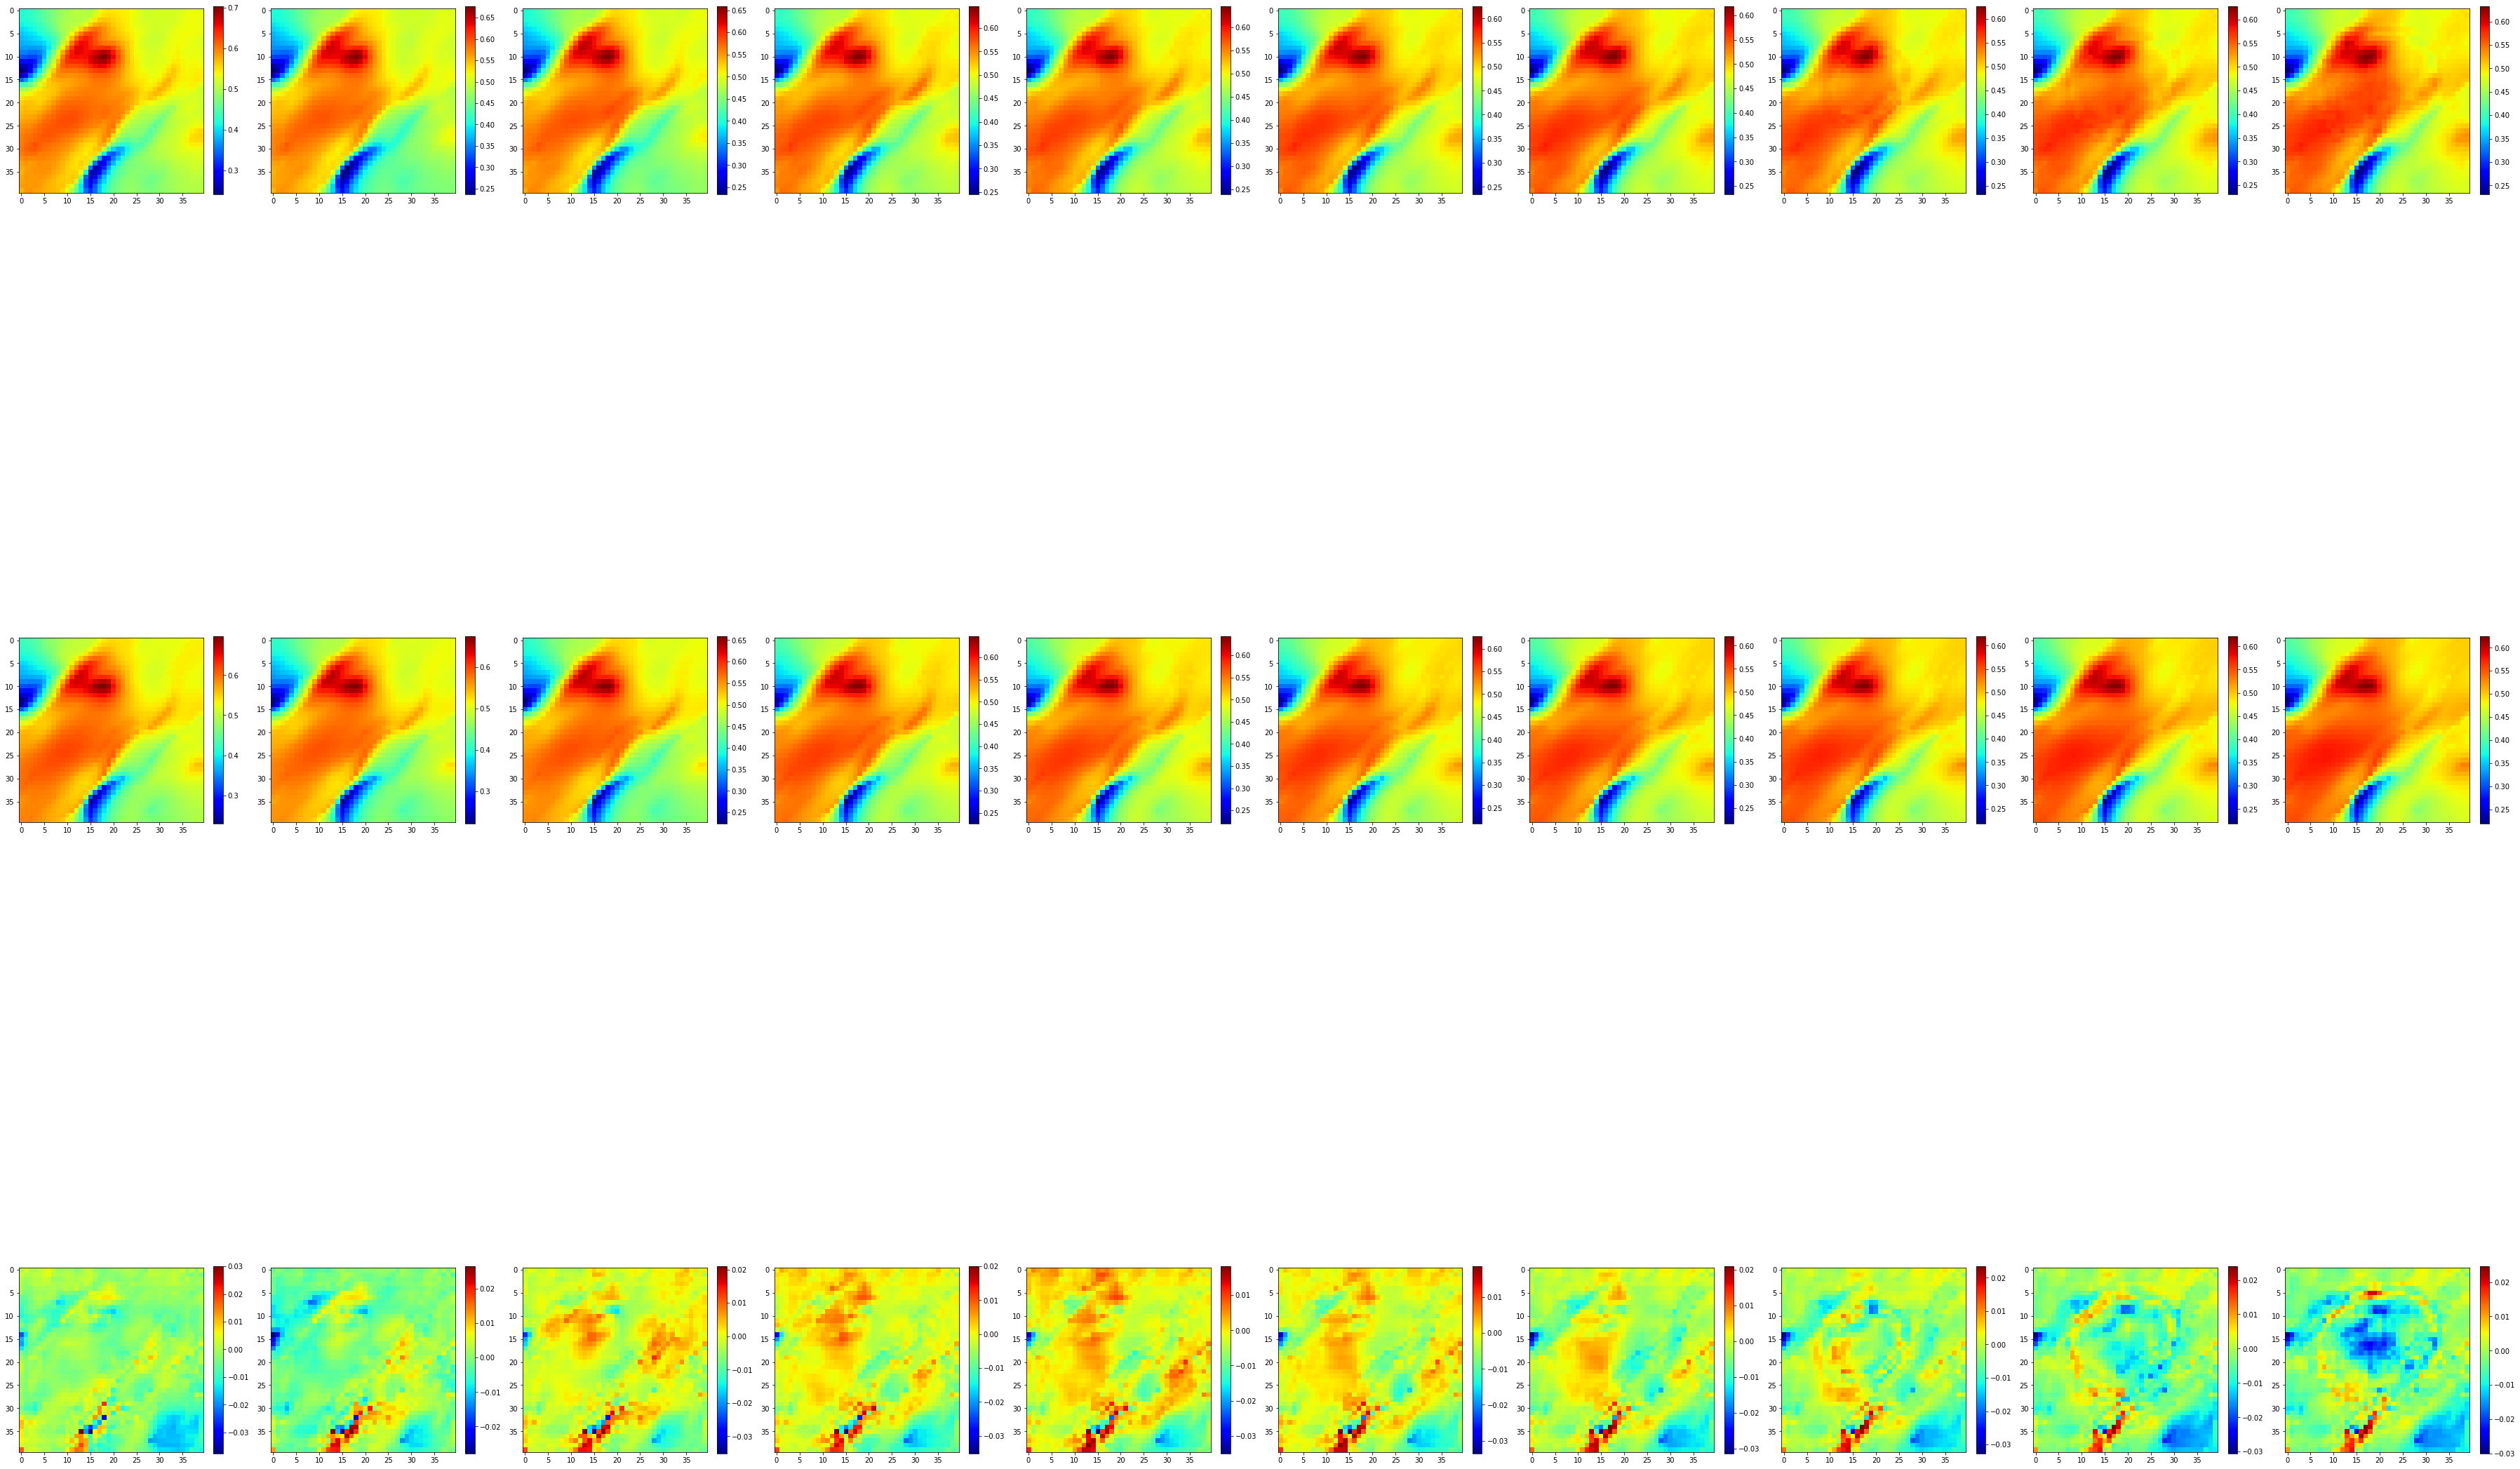

In [17]:
ind_case = [200]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, 0, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, 0, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, 0, :, :, i_tstep] - p_pred[k, 0, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

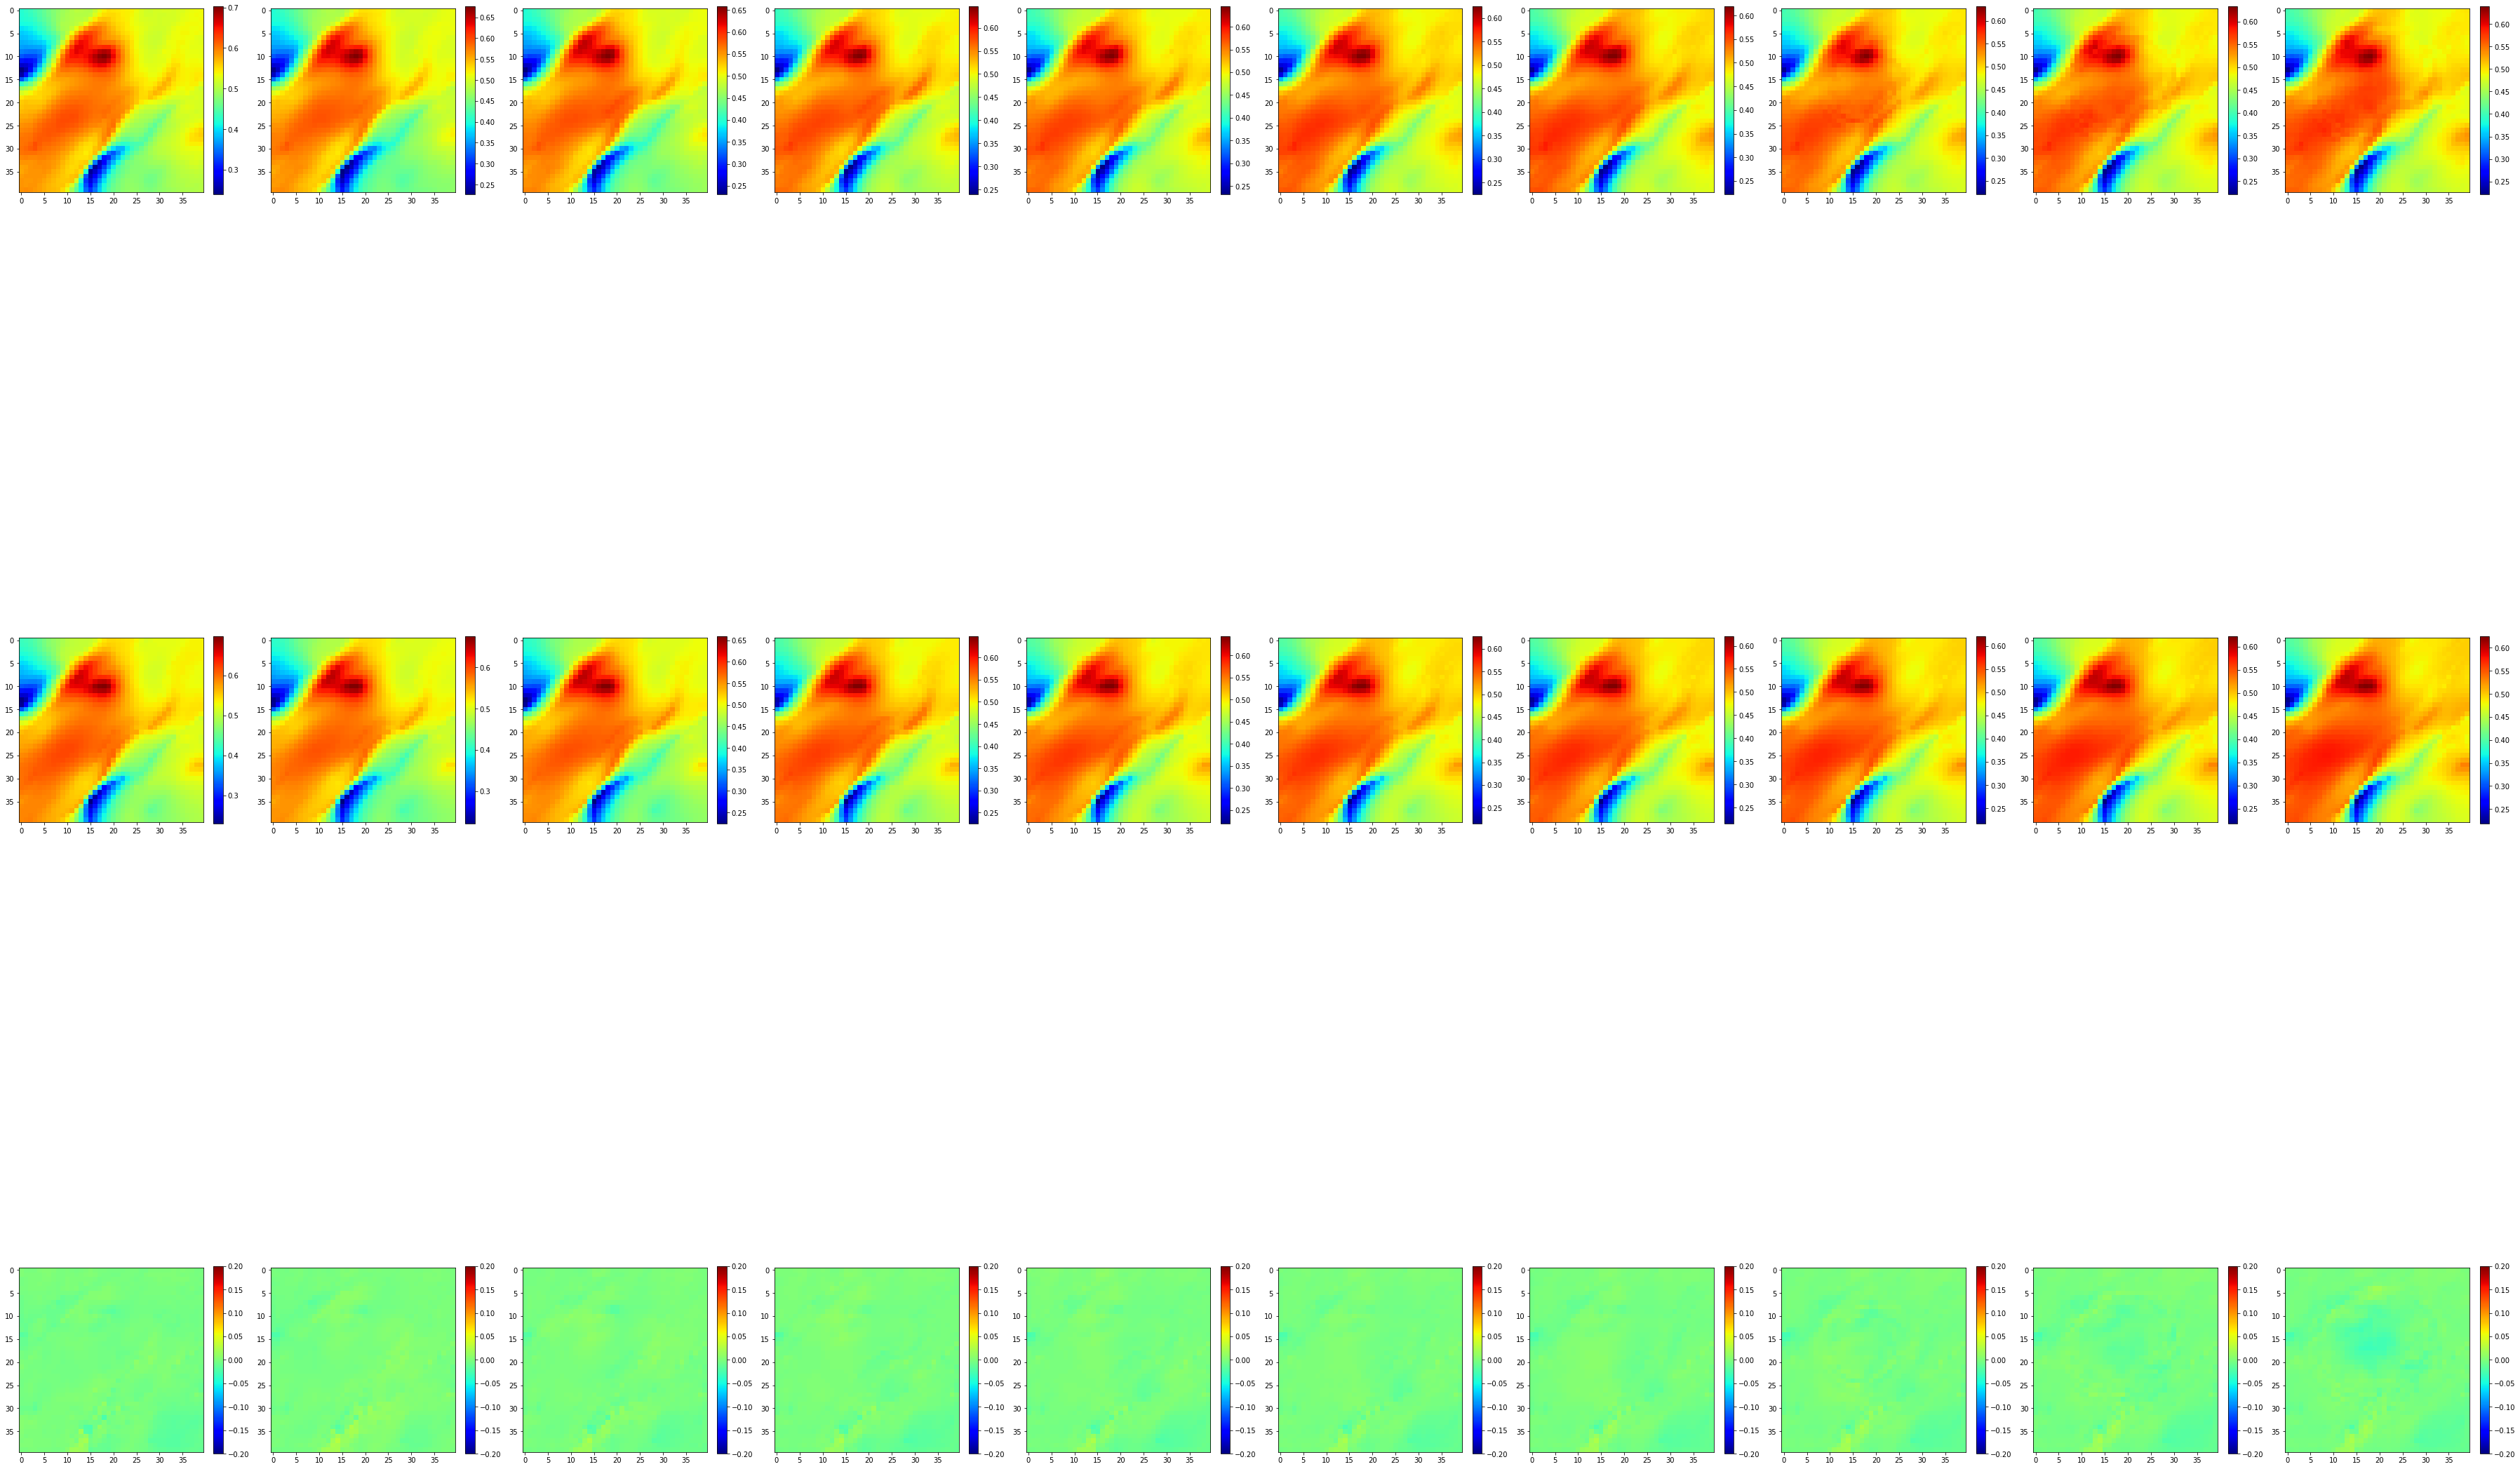

In [18]:
ind_z = 1
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep] - p_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

In [19]:
p_true = ((max_p[:, :, :, :, step_index] - min_p[:, :, :, :, step_index] + epsilon) * (p_true)+ min_p[:, :, :, :, step_index])  + p_t_mean[:, :, :, :, step_index]
p_pred = ((max_p[:, :, :, :, step_index] - min_p[:, :, :, :, step_index] + epsilon) * (p_pred) + min_p[:, :, :, :, step_index]) + p_t_mean[:, :, :, :, step_index]

In [20]:
p_true.shape

(423, 20, 40, 40, 10)

In [21]:
hw = h5py.File('p_pred_10steps_hd500_bs4_lr3e-4_filter_16_32_32_64.h5', 'w')
hw.create_dataset('p_pred', data = p_pred)
hw.create_dataset('p_true', data = p_true)
hw.close()

In [22]:
np.max(p_pred)

333.2031476472345

In [23]:
np.min(p_pred)

308.7944714979087

In [24]:
##Compute error
p_error = np.mean(np.abs(p_pred - p_true[:p_pred.shape[0],...])/(np.max(p_true[:p_pred.shape[0],...],  keepdims = True, axis = (1,2,3,4)) - np.min(p_true[:p_pred.shape[0],...], keepdims = True, axis = (1,2,3,4))), axis = (0, 1,2,3))

In [25]:
p_error

array([0.00707316, 0.00716101, 0.00735766, 0.00744995, 0.00733776,
       0.00724876, 0.00719661, 0.00715507, 0.00725522, 0.00733008])

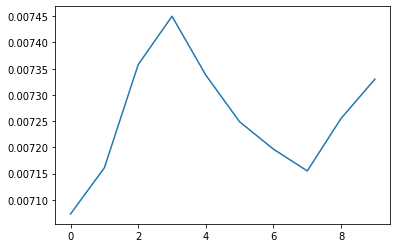

In [26]:
plt.figure()
plt.plot(p_error)
plt.show()

In [27]:
np.mean(p_error)

0.007256529149281496